## **1.Enviroment Setup**


---



### **1.1.Install Python Libraries**


In [2]:
!pip install rasterio -q
!pip install seaborn -q
!pip install xlsxwriter -q
!pip install matplotlib-scalebar -q
!pip install matplotlib-map-utils -q

### **1.2.Import Libraries**

In [3]:
import os
import sys
import glob
import pickle
import numba as nb
import numpy as np
import pandas as pd
import xlsxwriter
import rasterio

from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils import scale_bar
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

### **1.3.Mounting Google Drive**



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.4.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [5]:
image_paths = [
    '/content/drive/MyDrive/change-components/input_toydata/time_2000.tif',
    '/content/drive/MyDrive/change-components/input_toydata/time_2001.tif',
    '/content/drive/MyDrive/change-components/input_toydata/time_2002.tif',
]

# If you have a mask, define here:
mask_path = ''

### **1.5.Setting Paths to Output Files**

In [6]:
# Setting Output Directory Path for Data Storage on Google Drive
output_path = "/content/drive/MyDrive/change-components/output_toydata/"

# Check if the folder exists, if not, create the folder
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists.")

Folder already exists.


## **2.Data Preparation**

### **2.1.Setting Years of the Time Intervals**

In [7]:
years = [2000,2001,2002]

### **2.2.Setting the classes**

In [8]:
# Defining the ID and Name of the Classes
class_labels_dict = {
    1: {"name": "A", "color": "#00BFFF"},
    2: {"name": "B", "color": "#32CD32"},
    3: {"name": "C", "color": "#FFFF00"},
}

class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### **2.3 Apply Mask**

The code below applies a mask to a list of images and saves the resulting masked images as 8-bit TIFF files. If no mask is provided, the original images are saved unchanged. The function returns a list of paths to the saved masked images.

In [9]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a given mask to a series of image files and save the masked images as 8-bit TIFFs.

    Parameters:
    image_paths (list): List of paths to the images to which the mask will be applied.
    output_path (str): Directory to save the masked images.
    mask_path (str, optional): Path to the mask file. If None, no mask is applied.

    Returns:
    list: A list containing the paths to the saved masked images.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply the mask to each image specified in the image_paths
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Ensure the data type is uint8 and set the correct driver for TIFF files
            meta['dtype'] = 'uint8'
            meta['nodata'] = 0
            meta['driver'] = 'GTiff'
            meta['compress'] = 'lzw'

            # Read all bands of the image and apply mask if provided
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype('uint8')
            else:
                masked_data = image_data.astype('uint8')

            # Construct the path for the masked image
            base_name = os.path.basename(path).replace('.tif', '_masked.tif')
            masked_path = os.path.join(output_path, base_name)

            # Save the masked image
            with rasterio.open(masked_path, 'w', **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths

# Assuming image_paths, mask_path, and output_path are already defined
masked_image_paths = apply_mask_to_images(image_paths, output_path, mask_path)

# Print the paths of the saved masked images
for path in masked_image_paths:
    print(path)

/content/drive/MyDrive/change-components/output_toydata/time_2000_masked.tif
/content/drive/MyDrive/change-components/output_toydata/time_2001_masked.tif
/content/drive/MyDrive/change-components/output_toydata/time_2002_masked.tif


### **2.4 Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, black-bordered grid cells, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, draws black rectangles around each cell, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it. After defining the directory and suffix, the code gathers all matching raster files and plots them using these functions.

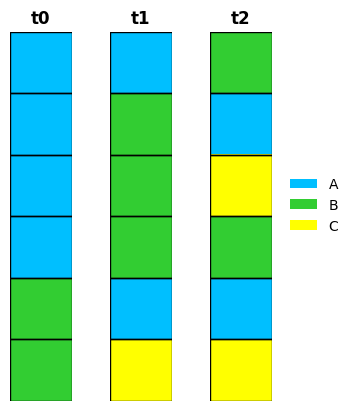

In [10]:
def find_images_with_suffix(directory, suffix):
    """
    Search for files in a directory with a given suffix.

    Parameters:
    directory (str): The directory to search.
    suffix (str): The suffix to match files.

    Returns:
    list: A list of paths to files matching the suffix.
    """
    return [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(suffix)]

def plot_rasters_auto(image_paths, class_map, years):
    """
    Automatically finds and plots rasters from a specified directory with
    specified colors and black borders.

    Parameters:
    image_paths (list): Automatically discovered list of raster file paths.
    class_map (dict): Dictionary containing class IDs with names and
    corresponding colors.
    years (list): List of years to be used as titles for each plot.
    """

    # Creates a color palette and normalizes class values for plotting
    cmap = ListedColormap([class_map[key]["color"] for key in sorted(class_map.keys())])
    norm = plt.Normalize(1, len(class_map))
    n_images = min(len(image_paths), len(years))
    fig, axs = plt.subplots(1,
                            n_images,
                            figsize=(n_images, 4),
                            constrained_layout=True)

    # Plots each image with the chosen colormap and adds a grid of black-bordered cells.
    for i, path in enumerate(image_paths[:n_images]):
        ax = axs[i] if n_images > 1 else axs
        with rasterio.open(path) as src:
            data = src.read(1).reshape(-1, 1)

        im = ax.imshow(data,
                       cmap=cmap,
                       norm=norm,
                       aspect='equal')

        titles = ["t0", "t1", "t2"]
        ax.set_title(f"{titles[i]}",
                     fontweight='bold')
        ax.axis('off')

        # Iterate through each cell to draw a black rectangular border
        for (j, k), val in np.ndenumerate(data):
            rect = Rectangle((k - 0.5, j - 0.5),
                             1, 1,
                             fill=False,
                             edgecolor='black',
                             lw=1)
            ax.add_patch(rect)

    # Custom legend elements
    legend_elements = [
    plt.Rectangle((0, 0), 1, 1,
                  facecolor=class_labels_dict[key]["color"],
                  # edgecolor="black",
                  # linewidth=1,
                  label=class_labels_dict[key]["name"])
    for key in sorted(class_labels_dict.keys())
    # if key != 0
    ]

    fig.legend(handles=legend_elements,
       loc='center right',
       bbox_to_anchor=(1.2, 0.5),
       frameon=False)

    # Export map to Google Drive
    plt.savefig(os.path.join(output_path,
                             "map_input.jpeg"),
                bbox_inches='tight',
                format='jpeg',
                dpi=300)

    plt.show()

# Directory to search for images
directory = output_path

# Suffix to match
suffix = "_masked.tif"

# Automatically find images
image_paths = find_images_with_suffix(directory, suffix)

# Plot the images with dynamic loading
plot_rasters_auto(image_paths, class_labels_dict, years)

## **3.Generate the Confusion Matrix**


---



In this section, the computer code will generate three confusion matrix. The first one is relate to each time interval. The second one is the confusion matrix for the temporal extent, which is represented for the first and last time point of the time extent. The last one is a confusion matrix that represents the sum of all time intervals.

Before generate the confusion matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the confusion matrix will be salved in the Google Drive in the ".csv" format.



In [11]:
def generate_mask_and_flatten_rasters(output_path, suffix='_masked.tif'):
    """
    Reads rasters with a specific suffix from a directory, applies a mask where
    data is zero, missing, or NaN, and flattens the non-masked values.

    Parameters:
    output_path (str): Directory containing raster files to process.
    suffix (str): File suffix to identify relevant rasters.

    Returns:
    list of numpy arrays: Flattened arrays of non-masked raster data for further
    analysis.
    """
    image_paths = [os.path.join(output_path, f)
                   for f in os.listdir(output_path) if f.endswith(suffix)]
    image_paths.sort()

    all_data = []
    all_masks = []

    # Read and mask all rasters
    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (data == 0) | (data == src.nodata) | np.isnan(data)
            all_masks.append(mask)
            all_data.append(data)

    # Create combined mask
    combined_mask = np.any(all_masks, axis=0)

    # Return flattened data
    return [data[~combined_mask].flatten() if np.any(combined_mask)
            else data.flatten() for data in all_data]

def generate_all_matrices(output_path, suffix='_masked.tif'):
    """Generate all required matrices and save to CSV"""
    # Get processed data
    flattened_data = generate_mask_and_flatten_rasters(output_path, suffix)

    # Get class labels and years from filenames
    raster_files = sorted([f for f in os.listdir(output_path)if f.endswith(suffix)])
    years = [f.split('_')[1] for f in raster_files]
    all_classes = np.unique(np.concatenate(flattened_data)).astype(int)

    # Generate interval matrices
    for i in range(len(flattened_data)-1):
        cm = confusion_matrix(flattened_data[i],
                              flattened_data[i+1],
                              labels=all_classes)
        pd.DataFrame(cm,
                     index=all_classes,
                     columns=all_classes
        ).to_csv(os.path.join(output_path,
                              f'confusion_matrix_{years[i]}-{years[i+1]}.csv'))

    # Generate extent matrix
    extent_matrix = confusion_matrix(flattened_data[0],
                                     flattened_data[-1],
                                     labels=all_classes)
    pd.DataFrame(extent_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_extent_{years[0]}-{years[-1]}.csv'))

    # Generate sum matrix
    sum_matrix = np.zeros((len(all_classes),
                           len(all_classes)),
                          dtype=int)
    for i in range(len(flattened_data)-1):
        sum_matrix += confusion_matrix(flattened_data[i],
                                       flattened_data[i+1],
                                       labels=all_classes)
    pd.DataFrame(sum_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_sum_{years[0]}-{years[-1]}.csv'))

    # Generate alternation matrix
    alternation_matrix = sum_matrix - extent_matrix
    pd.DataFrame(alternation_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'confusion_matrix_alternation_{years[0]}-{years[-1]}.csv'))

    return years, all_classes

def main(output_path):
    """Matrix generation workflow"""
    # Create output directory if needed
    os.makedirs(output_path, exist_ok=True)

    # Generate all matrices
    print("Generating confusion matrices...")
    years, all_classes = generate_all_matrices(output_path)

    # print(f"Generated matrices for {len(years)} time points")
    print(f"Detected classes: {all_classes}")
    print("Matrices saved in:", output_path)

if __name__ == "__main__":
    main(output_path)

Generating confusion matrices...
Detected classes: [1 2 3]
Matrices saved in: /content/drive/MyDrive/change-components/output_toydata/


## **4.Components of Change**


---

The code calculates components of change from confusion matrices generetaed in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of quantity, the exchanges, and shifts. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time slice, aggregates the results, and exports the outcomes to a CSV file.

In [12]:
class ComponentCalculator:
    def __init__(self, confusion_matrix):
      """
      Initialize with a confusion matrix, convert data types, and set up
      structure for class components
      """
      self.matrix = confusion_matrix.astype(int)
      self.num_classes = confusion_matrix.shape[0]
      self.class_components = []
      self.total_components = {
          'Quantity_Gain': 0, 'Quantity_Loss': 0,
          'Exchange_Gain': 0, 'Exchange_Loss': 0,
          'Shift_Gain': 0, 'Shift_Loss': 0
        }

    def calculate_components(self):
      """
      Calculate change components for each class based on the confusion matrix
      """
      for class_idx in range(self.num_classes):
          gain_sum = np.sum(self.matrix[:, class_idx])
          loss_sum = np.sum(self.matrix[class_idx, :])
          q_gain = max(0, gain_sum - loss_sum)
          q_loss = max(0, loss_sum - gain_sum)
          mutual = np.sum(np.minimum(
              self.matrix[class_idx, :],
              self.matrix[:, class_idx]
          ))
          exchange = mutual - self.matrix[class_idx, class_idx]
          total_trans = loss_sum - self.matrix[class_idx, class_idx]
          shift = max(0, total_trans - q_loss - exchange)
          self.class_components.append({
              'Quantity_Gain': q_gain,
              'Quantity_Loss': q_loss,
              'Exchange_Gain': exchange,
              'Exchange_Loss': exchange,
              'Shift_Gain': shift,
              'Shift_Loss': shift
          })
      return self

def process_matrix(matrix_type):
    """
    Process different types of matrices, calculate components, and compile
    results.
    """
    results = []

    try:
        # Determine file name based on matrix type and load data
        if matrix_type == 'extent':
            fname = f'confusion_matrix_extent_{years[0]}-{years[-1]}.csv'
        elif matrix_type == 'sum':
            fname = f'confusion_matrix_sum_{years[0]}-{years[-1]}.csv'
        else:
            fname = f'confusion_matrix_{matrix_type}.csv'

        df = pd.read_csv(os.path.join(output_path, fname), index_col=0)
        calc = ComponentCalculator(df.values).calculate_components()

        for idx, cls in enumerate(class_labels):
            comp = calc.class_components[idx]
            for component in ['Quantity', 'Exchange', 'Shift']:
                if matrix_type in ['extent', 'sum'] and component in ['Exchange', 'Shift']:
                    component_name = f"Allocation_{component}"
                else:
                    component_name = component
                results.append({
                    'Time_Interval': matrix_type,
                    'Class': cls,
                    'Component': component_name,
                    'Gain': comp[f'{component}_Gain'],
                    'Loss': comp[f'{component}_Loss']
                })

    except FileNotFoundError:
        print(f"Missing {matrix_type} matrix")

    return results

def main(output_path):
    """
    Main function to process all matrices and generate a CSV with the results.
    """
    # Process matrices and gather results
    all_results = []

    # Process all matrices for each year and specific matrix types
    for t in range(len(years)-1):
        all_results.extend(process_matrix(f"{years[t]}-{years[t+1]}"))

    all_results.extend(process_matrix('extent'))
    all_results.extend(process_matrix('sum'))

    # Handle alternation specifically
    try:
        alternation_matrix = pd.read_csv(
            os.path.join(output_path,
                         f'confusion_matrix_alternation_{years[0]}-{years[-1]}.csv'),
            index_col=0
        ).values.astype(int)

        calc = ComponentCalculator(np.abs(alternation_matrix)).calculate_components()

        for idx, cls in enumerate(class_labels):
            comp = calc.class_components[idx]
            all_results.extend([{
                'Time_Interval': 'alternation',
                'Class': cls,
                'Component': 'Alternation_Exchange',
                'Gain': comp['Exchange_Gain'],
                'Loss': comp['Exchange_Loss']
            }, {
                'Time_Interval': 'alternation',
                'Class': cls,
                'Component': 'Alternation_Shift',
                'Gain': comp['Shift_Gain'],
                'Loss': comp['Shift_Loss']
            }])

    except FileNotFoundError:
        print("Alternation matrix missing")

    # Export final CSV
    pd.DataFrame(all_results).to_csv(
        os.path.join(output_path, 'change_components.csv'),
        index=False
    )
    print("Components of change have been calculated and saved.")
    print(f"CSV file saved in: {output_path}")

if __name__ == "__main__":
    main(output_path)

Components of change have been calculated and saved.
CSV file saved in: /content/drive/MyDrive/change-components/output_toydata/


## **5.Graphics**

---



### **5.1 Setting the parameters for the graphics**

In [13]:
# Read the generated CSV file
csv_path = os.path.join(output_path, 'change_components.csv')
df = pd.read_csv(csv_path)

# Common color definitions for components
components_color = {
    'Quantity': '#1f77b4',
    'Exchange': '#ffd700',
    'Shift': '#2ca02c',
    'Allocation_Exchange': '#ffd700',
    'Allocation_Shift': '#2ca02c',
    'Alternation_Exchange': '#ff8080',
    'Alternation_Shift': '#990099'
}

# Desired order for legend and bars
component_order = [
    'Quantity',
    'Allocation_Exchange',
    'Allocation_Shift',
    'Alternation_Exchange',
    'Alternation_Shift'
]

# Common figure setup
figsize = (10, 6)
title_fontsize = 18
label_fontsize = 16
tick_labelsize = 16
legend_fontsize = 14


### **5.2 Change Components by Time Interval**

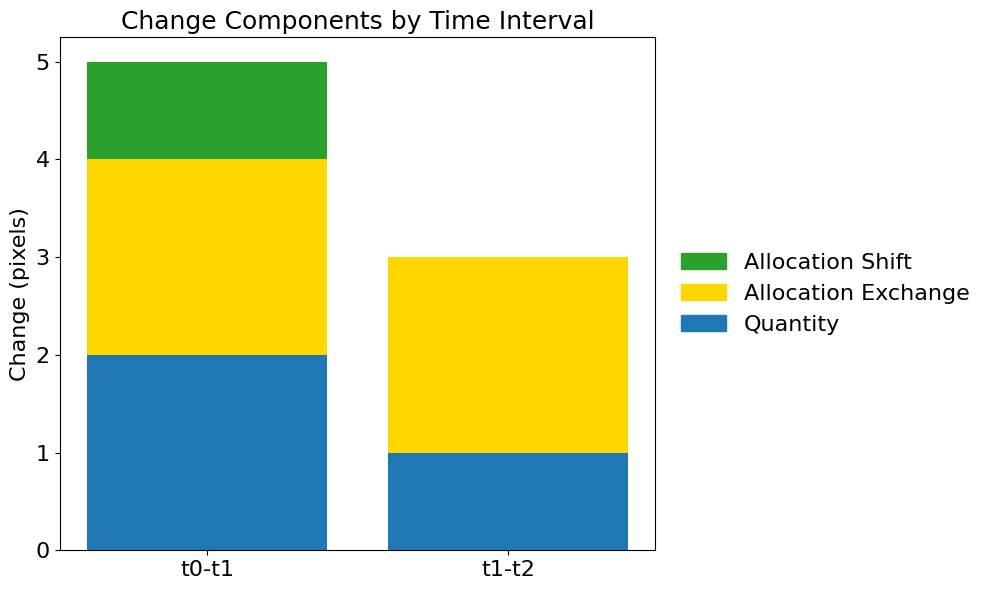

In [14]:
# Filter only time intervals information
time_df = df[df['Time_Interval'].str.contains('-')]

# Prepare data structure
totals = time_df.groupby(['Time_Interval', 'Component'])['Gain'].sum().unstack()

# Create figure and axes
plt.close('all')
fig, ax = plt.subplots(figsize = figsize)

# Plot bars for totals
for idx, comp in enumerate(['Quantity',
                            'Exchange',
                            'Shift']):
    bottom_values = totals[['Quantity',
                            'Exchange',
                            'Shift']].iloc[:, :idx].sum(axis=1) if idx > 0 else 0
    ax.bar(totals.index, totals[comp],
           label=comp,
           color=components_color[comp],
           edgecolor='none',
           bottom=bottom_values)

# Formating axes
ax.set_ylabel('Change (pixels)',
              fontsize=label_fontsize)
ax.set_title('Change Components by Time Interval',
             fontsize=title_fontsize)
ax.tick_params(axis='both',
               which='major',
               labelsize=tick_labelsize)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticks(totals.index)
ax.set_xticklabels(['t0-t1', 't1-t2'])

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color=components_color['Shift'], label='Allocation Shift'),
    plt.Rectangle((0,0),1,1, color=components_color['Exchange'], label='Allocation Exchange'),
    plt.Rectangle((0,0),1,1, color=components_color['Quantity'], label='Quantity')
]

ax.legend(handles=legend_elements,
          loc='center left',
          bbox_to_anchor=(1.01, 0.5),
          fontsize=16,
          frameon=False)


# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(output_path, "graphic_change_components_time_interval.jpeg"),
            format='jpeg',
            dpi=300)
plt.show()

### **5.3 Change Components Overall**

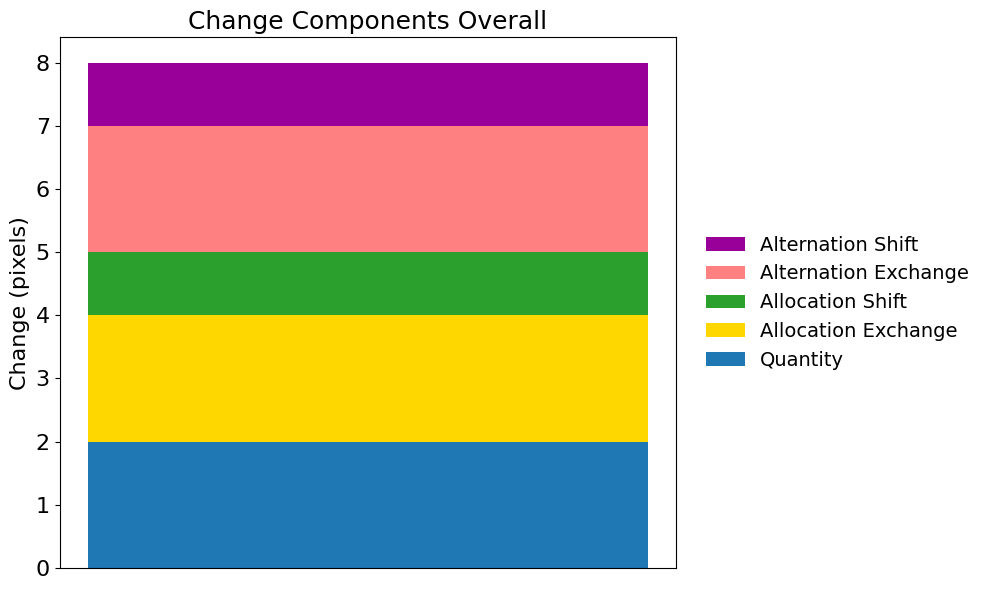

In [15]:
# Calculate component totals
component_totals = {
    'Quantity': df[(df['Component'] == 'Quantity') &
                  (df['Time_Interval'] == 'extent')]['Gain'].sum(),

    'Allocation_Exchange': df[(df['Component'] == 'Allocation_Exchange') &
                  (df['Time_Interval'] == 'extent')]['Gain'].sum(),

    'Allocation_Shift': df[(df['Component'] == 'Allocation_Shift') &
               (df['Time_Interval'] == 'extent')]['Gain'].sum(),

    'Alternation_Exchange': df[df['Component'] == 'Alternation_Exchange']['Gain'].sum(),


    'Alternation_Shift': df[df['Component'] == 'Alternation_Shift']['Gain'].sum()
}

# Create figure and axes
plt.close('all')
fig, ax = plt.subplots(figsize=figsize)

# Plot bars
bottom = 0
bars = []
labels = []

for component in component_order:
    value = component_totals.get(component, 0)
    bar = ax.bar(
        x=0,
        height=value,
        bottom=bottom,
        color=components_color[component],
        edgecolor='none',
        width=1
    )
    bars.append(bar[0])
    labels.append(component.replace('_', ' '))
    bottom += value

# Formating axes
ax.set_ylabel('Change (pixels)',
              fontsize=label_fontsize)
ax.set_title('Change Components Overall',
             fontsize=title_fontsize)
ax.tick_params(axis='both',
               which='major',
               labelsize=tick_labelsize)
ax.xaxis.set_visible(False)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1,
              facecolor=components_color[component],
              # edgecolor="black",
              # linewidth=1,
              label=component.replace('_',' '))
    for component in reversed([
        'Quantity',
        'Allocation_Exchange',
        'Allocation_Shift',
        'Alternation_Exchange',
        'Alternation_Shift'
    ])
]
ax.legend(handles=legend_elements,
          loc='center left',
          bbox_to_anchor=(1.02, 0.5),
          fontsize=legend_fontsize,
          frameon=False)

# Save and show plot
plt.tight_layout()
plt.savefig(
    os.path.join(output_path, "graphic_change_component_overall.jpeg"),
    format='jpeg',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

### **5.4 Change Componentes by Class**

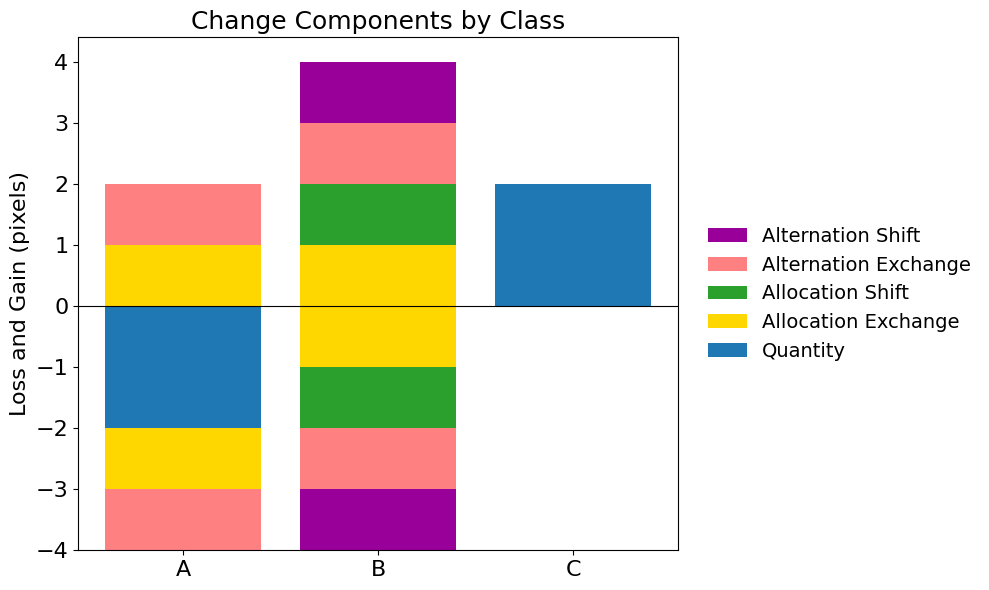

In [16]:
class ComponentVisualizer:
    """Class to visualize components including alternation"""

    @staticmethod
    def plot_gain_loss_stacked(class_labels_dict, title, output_path):
        """Plot gains and losses with alternation components"""
        # Access predefined parameters from global scope
        global df, components_color, component_order
        global figsize, title_fontsize, label_fontsize, tick_labelsize, legend_fontsize

        # Filter data using original criteria
        filtered_df = df[df['Time_Interval'].isin(['extent', 'alternation'])]

        # Class sorting logic
        existing_classes = [cls for cls in filtered_df['Class'].unique() if cls != 0]
        class_totals = []

        for cls in existing_classes:
            class_data = filtered_df[filtered_df['Class'] == cls]
            quantity_gain = class_data[class_data['Component'] == 'Quantity']['Gain'].sum()
            quantity_loss = class_data[class_data['Component'] == 'Quantity']['Loss'].sum()
            class_totals.append((cls, quantity_gain - quantity_loss))

        sorted_classes = sorted(class_totals, key=lambda x: x[1])
        ordered_classes = [cls for cls, _ in sorted_classes]

        # Create figure using predefined dimensions
        fig, ax = plt.subplots(figsize=figsize)
        fig.subplots_adjust(left=0.1, right=0.75)
        x_positions = np.arange(len(ordered_classes))
        width = 0.8

        # Plot each class using predefined component order
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[filtered_df['Class'] == cls]

            gain_bottom = loss_bottom = 0
            for comp in component_order:
                # Plot gains
                gains = class_data[class_data['Component'] == comp]['Gain'].sum()
                ax.bar(x_positions[idx],
                       gains,
                       width,
                       bottom=gain_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                gain_bottom += gains

                # Plot losses
                losses = -class_data[class_data['Component'] == comp]['Loss'].sum()
                ax.bar(x_positions[idx],
                       losses,
                       width,
                       bottom=loss_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                loss_bottom += losses

        # Axis formatting with predefined parameters
        class_names = [class_labels_dict.get(cls, {}).get("name", f"{cls}") for cls in ordered_classes]
        ax.set_xticks(x_positions)
        ax.set_xticklabels(class_names,
                           rotation=0,
                           ha='center',
                           fontsize=tick_labelsize)
        ax.axhline(0,
                   color='black',
                   linewidth=0.8)
        ax.set_ylabel('Loss and Gain (pixels)',
                      fontsize=label_fontsize)
        ax.set_title(title,
                     fontsize=title_fontsize)
        ax.tick_params(axis='both',
                       which='major',
                       labelsize=tick_labelsize)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        # Legend
        legend_elements = [
            plt.Rectangle((0,0),1,1,
                facecolor=components_color[comp],
                label=comp.replace('_', ' '))
            for comp in reversed(component_order)
        ]
        ax.legend(handles=legend_elements,
                loc='center left',
                bbox_to_anchor=(1.02, 0.5),
                fontsize=legend_fontsize,
                frameon=False)

        # Save and show plot
        plt.tight_layout()
        plt.savefig(
            os.path.join(output_path,
                         "graphic_change_component_change_class.jpeg"),
            format='jpeg',
            dpi=300,
            bbox_inches='tight'
        )
        plt.show()

ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict,
    "Change Components by Class",
    output_path
)

## **6. Trajectory Classification**


---



In [17]:
@nb.njit(nogil=True, cache=True)
def classify_pixel(pixel_series):
    """Numba-optimized trajectory classification (20-50x faster)"""
    if pixel_series[0] == 0:
        return 0

    start = pixel_series[0]
    end = pixel_series[-1]
    has_variation = False
    direct_transition = False

    # First pass: check all conditions in single loop
    for i in range(len(pixel_series)-1):
        current = pixel_series[i]
        next_val = pixel_series[i+1]

        # Check for any variation
        if not has_variation and current != next_val:
            has_variation = True

        # Check for direct transition
        if not direct_transition and current == start and next_val == end:
            direct_transition = True

    # Trajectory 1:
    if not has_variation:
        return 1

    # Trajectory 2:
    if start == end:
        return 2

    # Trajectory 3:
    if direct_transition:
        return 3

    # Trajectory 4:
    return 4

@nb.njit(nogil=True, parallel=True)
def process_stack_parallel(stack, height, width):
    """Parallel processing of raster stack"""
    result = np.zeros((height, width), dtype=np.uint8)

    for y in nb.prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(stack[:, y, x])

    return result

class TrajectoryAnalyzer:
    @staticmethod
    def process_rasters(output_path, suffix='_masked.tif'):
        """Optimized raster processing with chunked loading"""
        # Validate directory
        os.makedirs(output_path, exist_ok=True)
        if not os.path.isdir(output_path):
            raise ValueError(f"Path must be a directory: {output_path}")

        # Find input files
        raster_files = sorted([
            os.path.join(output_path, f)
            for f in os.listdir(output_path)
            if f.endswith(suffix)
        ])
        if not raster_files:
            raise ValueError(f"No files found with suffix '{suffix}'")

        # Load metadata
        with rasterio.open(raster_files[0]) as src:
            meta = src.meta
            height, width = src.shape

        # Process in memory-friendly chunks
        chunk_size = 500
        result = np.zeros((height, width),
                          dtype=np.uint8)

        for y_start in range(0, height, chunk_size):
            y_end = min(y_start + chunk_size, height)
            chunk_height = y_end - y_start

            # Load chunk data
            stack = np.zeros((len(raster_files),
                              chunk_height,
                              width),
                             dtype=np.uint8)
            for i, f in enumerate(raster_files):
                with rasterio.open(f) as src:
                    stack[i] = src.read(1, window=((y_start, y_end), (0, width)))

            # Process chunk
            result[y_start:y_end] = process_stack_parallel(stack,
                                                           chunk_height,
                                                           width)

        # Save results
        meta.update({
            'dtype': 'uint8',
            'nodata': 0,
            'count': 1,
            'compress': 'lzw'
        })
        output_file = os.path.join(output_path, 'trajectory.tif')
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(result, 1)

        return output_file

if __name__ == "__main__":
    TrajectoryAnalyzer.process_rasters(output_path)
    print(f"Processing complete! Results saved to: {output_path}")

Processing complete! Results saved to: /content/drive/MyDrive/change-components/output_toydata/


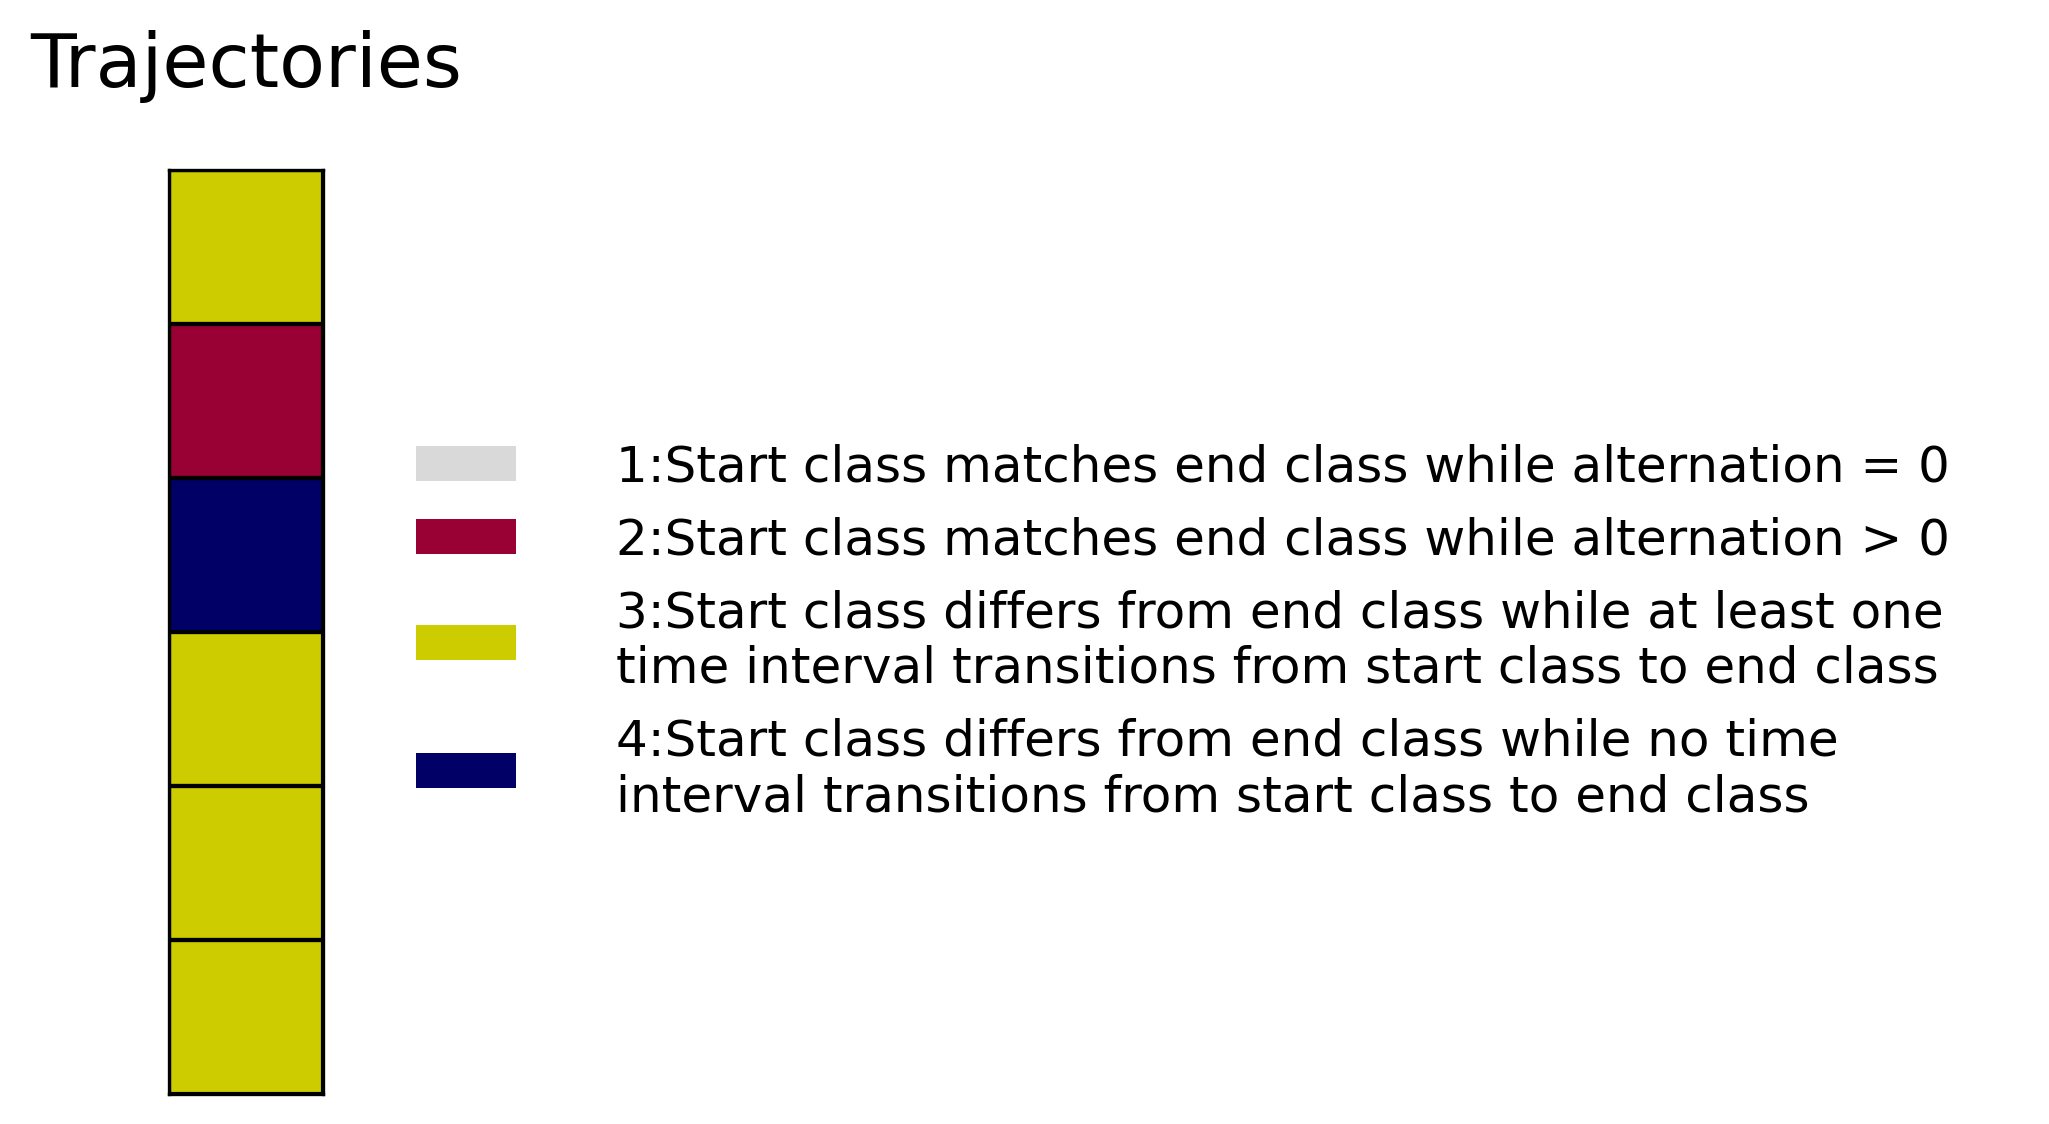

Map saved successfully in the folder: /content/drive/MyDrive/change-components/output_toydata/


In [26]:
# Set the path for the input raster file using a predefined output directory
raster_path = os.path.join(output_path, 'trajectory.tif')

# Define the resolution (dots per inch) of the output image
dpi = 300

# Define legend elements with custom labels and colors for different categories
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor='#d9d9d9', label='1:Start class matches end class while alternation = 0'),
    Rectangle((0, 0), 1, 1, facecolor='#990033', label='2:Start class matches end class while alternation > 0'),
    Rectangle((0, 0), 1, 1, facecolor='#cccc00', label='3:Start class differs from end class while at least one \ntime interval transitions from start class to end class'),
    Rectangle((0, 0), 1, 1, facecolor='#000066', label='4:Start class differs from end class while no time \ninterval transitions from start class to end class')
]

# Define a custom color map for visualizing the raster data
cmap = ListedColormap([
    # '#d9d9d9',  # Trajectory 1
    '#990033',  # Trajectory 2
    '#cccc00',  # Trajectory 3
    '#000066',  # Trajectory 4
])

# Open the raster file using rasterio
with rasterio.open(raster_path) as src:
    # Read the raster data at original resolution
    data = src.read(1)

    # Store original transformation settings
    original_transform = src.transform
    # Get spatial bounds of the raster data
    left, bottom, right, top = src.bounds

    # Create a figure and a set of subplots with custom dimensions and DPI
    fig, ax = plt.subplots(figsize=(8, 4), dpi=dpi)

    # Display the raster data using the defined color map and spatial extent
    img = ax.imshow(
        data,
        cmap=cmap,
        extent=[left, right, bottom, top],
        interpolation='none'
    )

    # Function to format tick marks as whole numbers
    def format_ticks(x, _):
        return f'{x:.0f}'

    # Set up formatting for x and y axis tick marks
    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    # Maintain aspect ratio of the image
    ax.set_aspect('equal')

    # Customize major tick parameters
    ax.tick_params(axis='both',
                   which='major',
                   labelsize=14,
                   labelrotation=0,
                   pad=8)

    # Draw black borders around each pixel in the raster image
    for (j, i), val in np.ndenumerate(data):
        rect = Rectangle((i, j-4), 1, 1,
                         fill=False,
                         edgecolor='black',
                         lw=1)
        ax.add_patch(rect)

    ax.set_xticks([])
    ax.set_yticks([])

    # Create and place a legend with custom formatting
    legend = ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        borderpad=1.2,
        handletextpad=2.0,
        columnspacing=2,
    )

    # Set title of the plot with custom font size and padding
    plt.title("Trajectories",
              fontsize=18, pad=20)

    # Save the resulting plot to as a JPEG file
    plt.savefig(
        os.path.join(output_path,
                     'map_trajectories.jpeg'),
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.5,
        pil_kwargs={'optimize': True,
                    'quality': 95}
    )

# Display the plot
plt.show()

# Close the plot to free up memory
plt.close()

# Print a confirmation message when the map is completed
print("Map saved successfully in the folder:", output_path)


Trajectory Percentages:
Trajectory 2: 16.67%
Trajectory 3: 66.67%
Trajectory 4: 16.67%


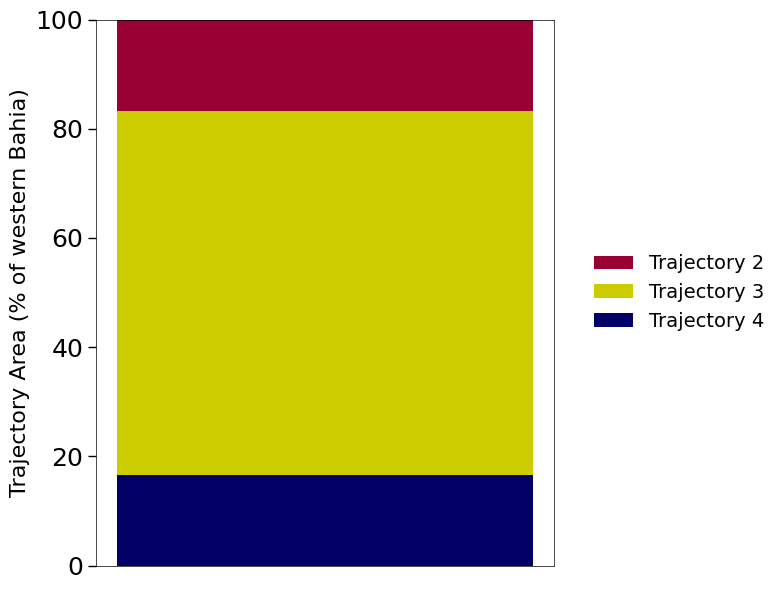

In [37]:
def plot_trajectory_distribution(output_path):
    """
    Generates trajectory distribution bar chart from raster data
    with consistent styling and proper frame
    """
    # Path to trajectory raster
    raster_path = os.path.join(output_path, 'trajectory.tif')

    # Read raster data
    with rasterio.open(raster_path) as src:
        traj_data = src.read(1)
        nodata = src.nodata

    # Filter nodata values and count trajectories
    masked_traj = np.ma.masked_where(traj_data == nodata, traj_data)
    unique, counts = np.unique(masked_traj.compressed(), return_counts=True)
    total_pixels = counts.sum()

    # Calculate percentages
    percentages = {k: (v/total_pixels)*100 for k, v in zip(unique, counts)}

    # Print trajectory percentages
    print("\nTrajectory Percentages:")
    for traj, percentage in percentages.items():
        print(f"Trajectory {traj}: {percentage:.2f}%")  # Format to 2 decimal places

    # Define trajectories to show (4, 3, 2) and colors
    ordered_trajs = [4, 3, 2]
    colors = {
        4: '#000066',  # Dark blue
        3: '#cccc00',  # Gold
        2: '#990033'   # Dark red
    }

    # Calculate maximum Y value (round up to nearest 10)
    max_percentage = sum(percentages.get(traj, 0) for traj in ordered_trajs)
    y_max = np.ceil(max_percentage / 10) * 10  # Round up to nearest 10

    # Create figure with consistent styling
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot stacked bars
    bottom = 0
    for traj in ordered_trajs:
        if traj in percentages:
            ax.bar(0, percentages[traj],
                  bottom=bottom,
                  color=colors[traj],
                  width=0.4,
                  edgecolor='none')
            bottom += percentages[traj]

    # Formatting to match PDF style
    ax.set_ylabel('Trajectory Area (% of western Bahia)',
                 fontsize=16)
    # ax.set_title('Trajectory Distribution',
    #             fontsize=18)

    # Configure frame (box) - all spines visible
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(0.5)

    # Remove minor ticks and configure major ticks
    ax.tick_params(axis='y', which='minor', length=0)
    ax.tick_params(axis='y', which='major',
                  labelsize=18,
                  length=6,
                  width=1)

    # Set dynamic Y-axis limits
    ax.set_ylim(0, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(np.floor(y_max/5)))  # 5 nice intervals

    ax.xaxis.set_visible(False)  # No x-axis as it's a single bar

    # Remove grid lines
    ax.grid(False)

    # Legend
    legend_elements = [
        Patch(facecolor='#990033', label='Trajectory 2'),
        Patch(facecolor='#cccc00', label='Trajectory 3'),
        Patch(facecolor='#000066', label='Trajectory 4')
    ]
    ax.legend(handles=legend_elements,
             loc='center left',
             bbox_to_anchor=(1.05, 0.5),
             fontsize=14,
             frameon=False)

    # Save and show
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'graphic_trajectory_distribution.jpeg'),
                dpi=300,
                bbox_inches='tight')
    plt.show()

# Usage
if __name__ == "__main__":
    plot_trajectory_distribution(output_path)